In [1]:
import pandas as pd
from dysts.flows import Lorenz
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models.forecasting.nbeats import NBEATSModel
from darts.metrics.metrics import mse

[2022-03-11 12:01:01,120] WARNING | darts.models | Support for AutoARIMA is not available.To enable it, install u8darts[pmdarima] or u8darts[all].
[2022-03-11 12:01:01,123] WARNING | darts.models | Support for Facebook Prophet is not available. To enable it, install "darts", "u8darts[prophet]" or "u8darts[all]" (with pip);or "u8darts-all" (with conda).


In [2]:
import torch
torch.manual_seed(0)

import random
random.seed(0)

import numpy as np
np.random.seed(0)

In [3]:
def make_trajectory_given_ic(chaos_model, length, ic=None):
    if ic is not None:
        chaos_model.ic = ic
    trajectory = chaos_model.make_trajectory(length)
    return TimeSeries.from_values(trajectory)

def make_trajectories(chaos_model, n_samples, length, r):
    return [make_trajectory_given_ic(chaos_model, length, ic = r * np.random.rand(3)) for _ in range(n_samples)]

In [46]:
def plot_n_3d_trajectories(trajectories, predictions=None, n=16):
    gt = np.array([t[pd.RangeIndex(network_in, trajectory_length)].all_values().squeeze().T for t in trajectories[:n]])
    if predictions is not None:
        init = np.array([t[pd.RangeIndex(network_in+1)].all_values().squeeze().T for t in trajectories[:n]])
        preds = np.array([t.all_values().squeeze().T for t in predictions[:n]])

    data = np.concatenate((gt, preds)) if predictions is not None else gt
    xmin, ymin, zmin = data.min(axis=0).min(axis=1)
    xmax, ymax, zmax = data.max(axis=0).max(axis=1)

    if predictions is not None:
        mses = mse([t[pd.RangeIndex(network_in, trajectory_length)] for t in trajectories[:n]], predictions[:n])

    fig = plt.figure(figsize=(20, 16))

    if predictions is not None:
        fig.suptitle(f'MSE across {n} shown samples: {np.mean(mses):.3e}', y=0.92)

    h = int(np.sqrt(n))
    w = h if h * h == n else h + 1

    for i in range(n):
        ax = fig.add_subplot(h, w, i+1, projection='3d')
        ic = data[i, :, 0]
        title = f'(x0, y0, z0)={tuple(np.round(ic, 2))}'
        if predictions is not None:
            title = f'{title}\nMSE={mses[i]:.2e}'
        ax.set_title(title)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_zlim(zmin, zmax)

        ts = data[i, :, :]
        ax.plot3D(ts[0], ts[1], ts[2], label='ground truth')
        if predictions is not None:
            ax.plot3D(*preds[i, :, :], label='prediction', color='red')
            ax.plot3D(*init[i, :, :], label='start', color='cyan')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center')

    plt.tight_layout()
    return fig

In [5]:
trajectory_length = 1000
network_in = 5

lorenz = Lorenz()
lorenz.dt *= 50
train_set = make_trajectories(lorenz, r=20, n_samples=32, length=trajectory_length)

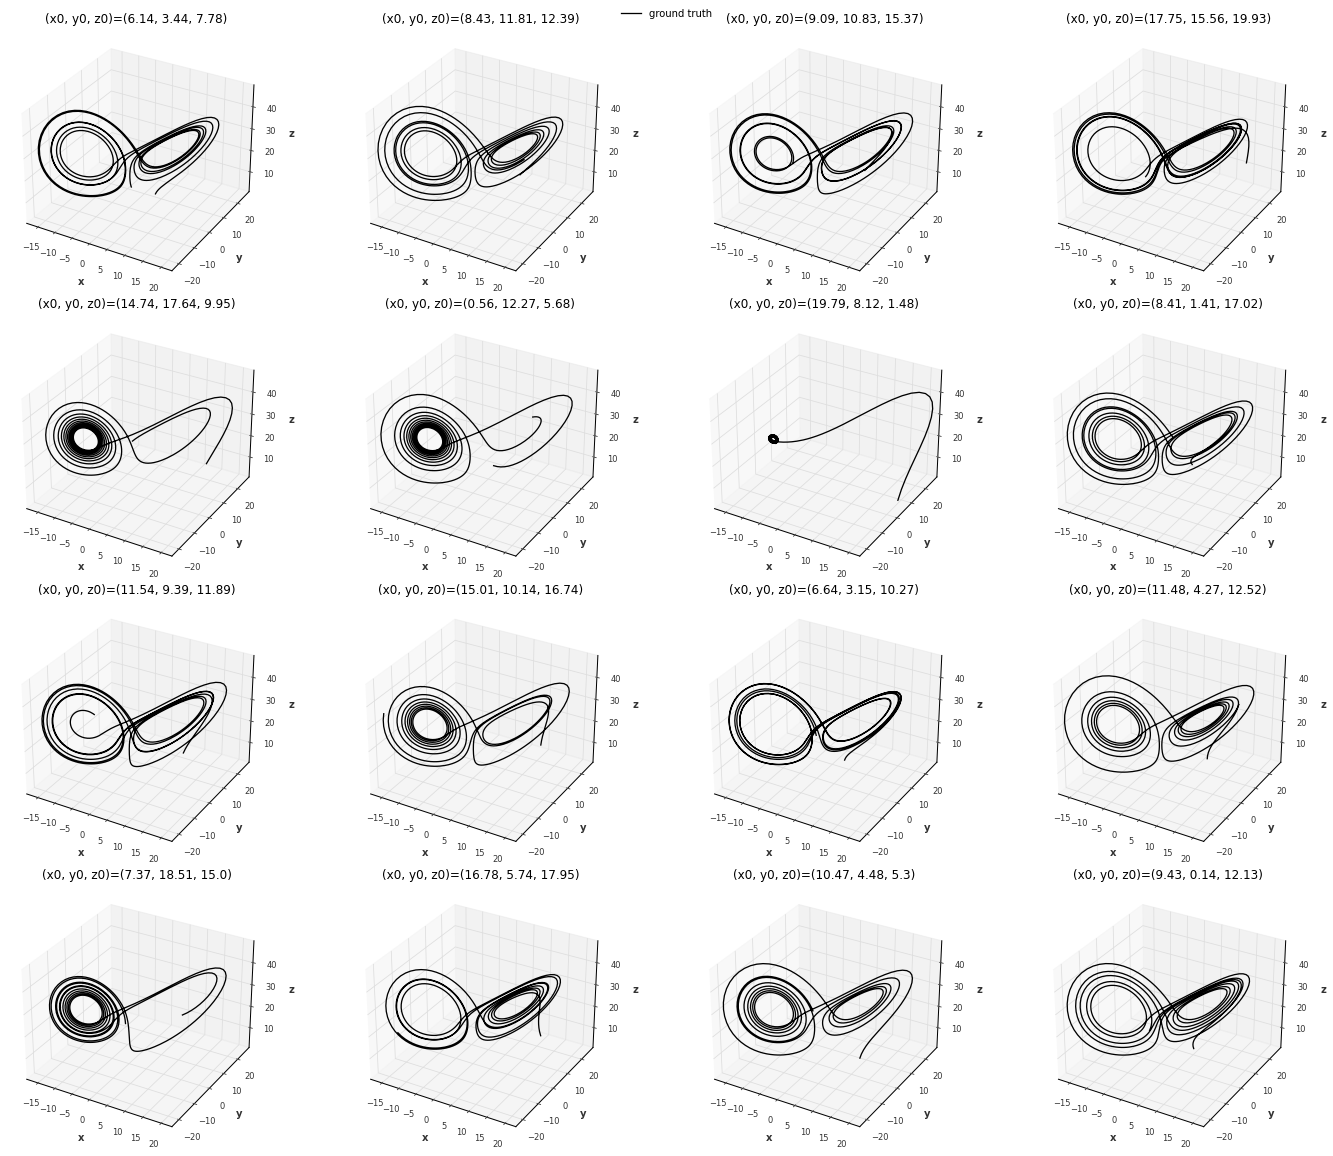

In [6]:
plot_n_3d_trajectories(train_set, n=16);

In [7]:
model = NBEATSModel(input_chunk_length=network_in, output_chunk_length=1, num_stacks=10, layer_widths=64)
model.fit(train_set, epochs=5);

[2022-03-11 12:02:13,866] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 31840 samples.
[2022-03-11 12:02:13,866] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 31840 samples.
[2022-03-11 12:02:13,890] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-11 12:02:13,890] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | stacks    | ModuleList | 142 K 
-----------------------------------------
142 K     Trainable params
415       Non-trainable params
142 K     Total params
1.141     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [ ]:
model.

In [8]:
test_set_same_initial = make_trajectories(lorenz, r=20, length=trajectory_length, n_samples=16)
preds_same = model.predict(trajectory_length-network_in, series=[t[pd.RangeIndex(stop=network_in)] for t in test_set_same_initial])

Predicting: 995it [00:00, ?it/s]

In [9]:
test_set_other_initial = make_trajectories(lorenz, r=-20, length=trajectory_length, n_samples=16)
preds_other = model.predict(trajectory_length-network_in, series=[t[pd.RangeIndex(stop=network_in)] for t in test_set_other_initial])

Predicting: 995it [00:00, ?it/s]

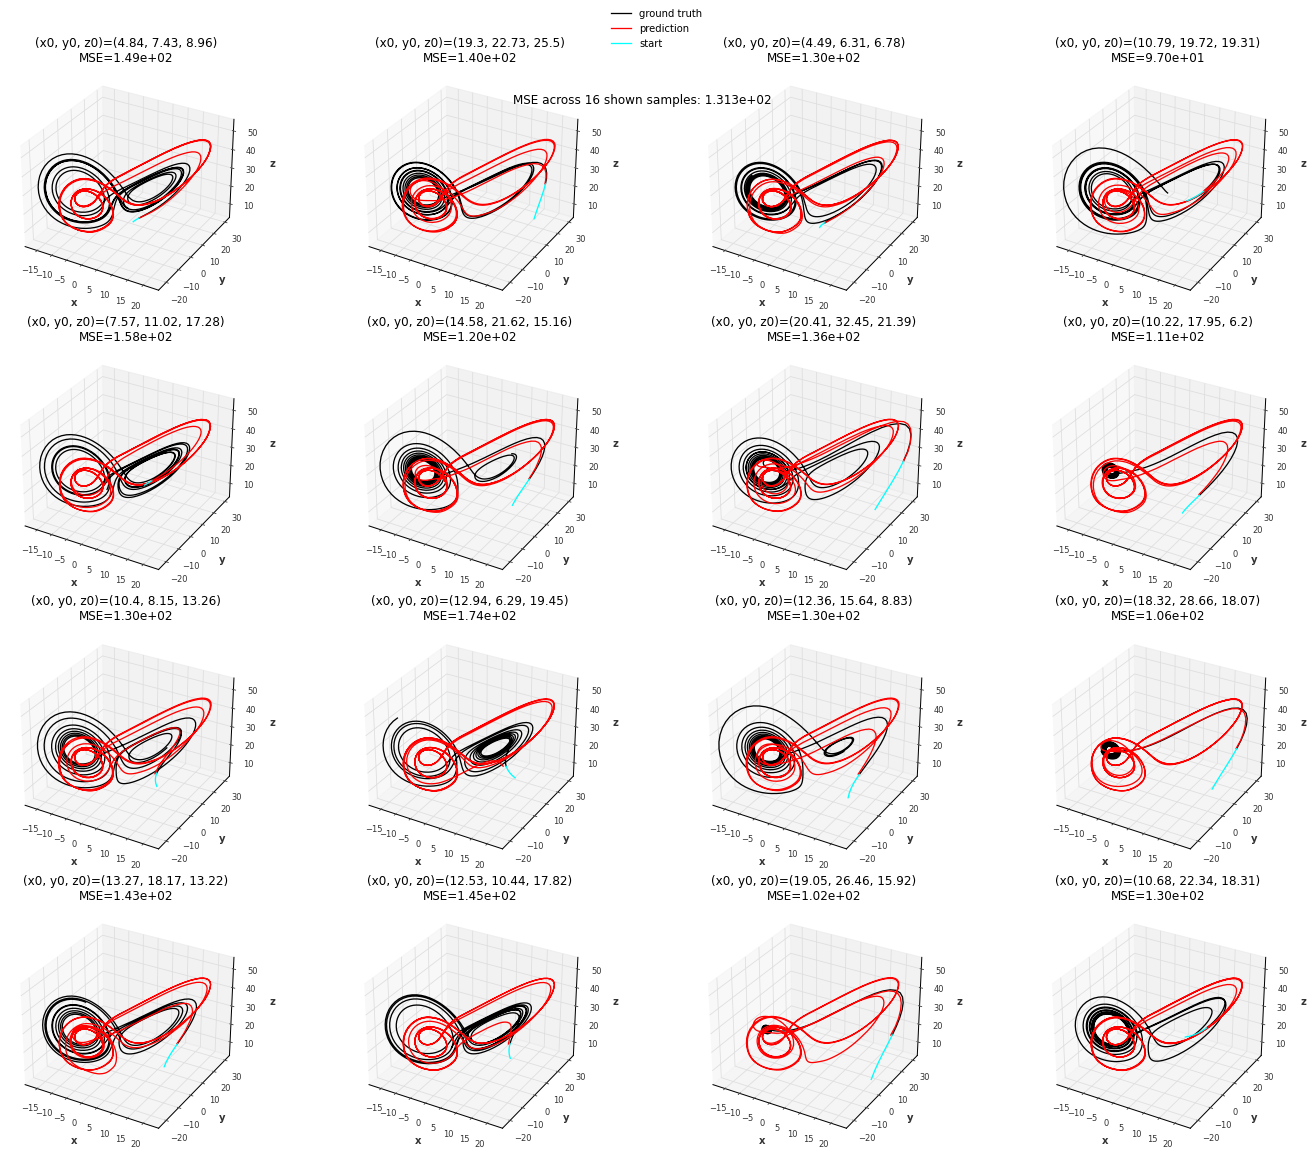

In [47]:
plot_n_3d_trajectories(test_set_same_initial, predictions=preds_same, n=16);

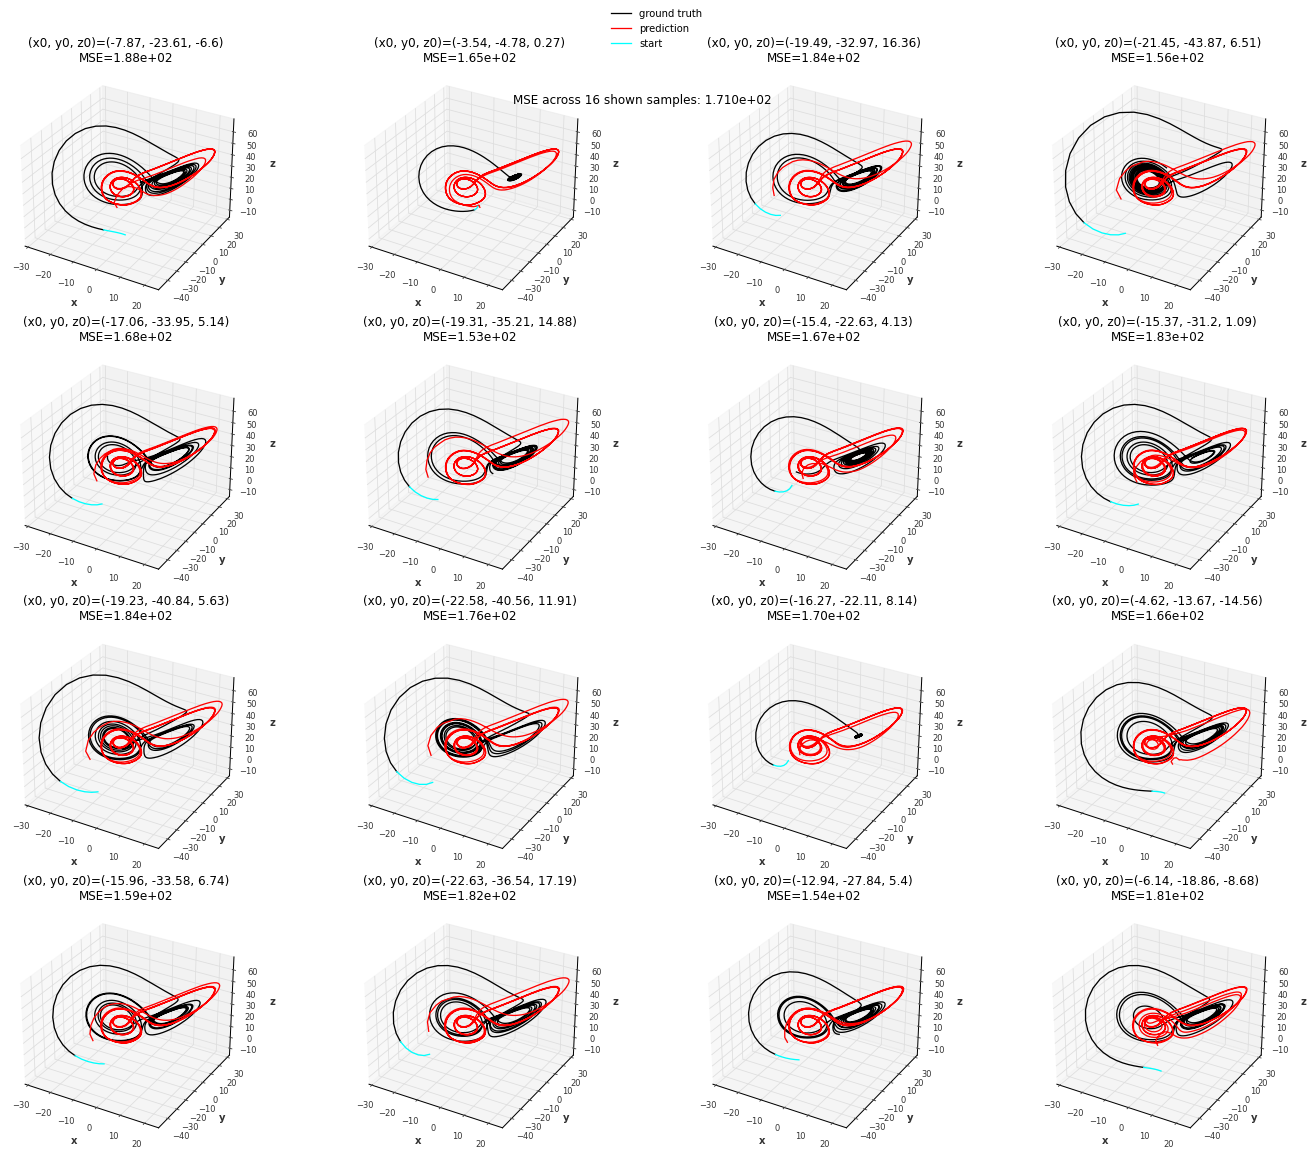

In [48]:
plot_n_3d_trajectories(test_set_other_initial, predictions=preds_other, n=16);